<a href="https://colab.research.google.com/github/gauravreddy08/learning-pytorch/blob/main/09_model_deployment_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09 | Model Deployment with **PyTorch**

https://www.learnpytorch.io/09_pytorch_model_deployment/

In [ ]:
!pip install -q wandb torchinfo gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import wandb

import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"[INFO] Device: \"{device}\"")

def set_seed(seed: int = 42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

[INFO] Device: "cuda"


In [ ]:
wandb_run = wandb.init(project="learning-pytorch")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!git clone https://github.com/gauravreddy08/learning-pytorch
!mv /content/learning-pytorch/going_modular .
!rm -rf learning-pytorch

Cloning into 'learning-pytorch'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 59 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), 1.77 MiB | 6.79 MiB/s, done.


## Getting the **data**

In [ ]:
import os
import zipfile

from pathlib import Path
import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    data = Path("data/")
    data_path = data /destination
    if(data_path.is_dir()):
      print("[INFO] Data already exists...")
    else:
      print(f"[INFO] Did not find {data_path} directory, creating one...")
      data_path.mkdir(parents=True, exist_ok=True)

      target_file = Path(source).name
      with open(data/target_file, 'wb') as f:
        request = requests.get(source)
        print(f"[INFO] Downloading {target_file} from {source}...")
        f.write(request.content)
      with zipfile.ZipFile(data/target_file, 'r') as zip_ref:
        print(f"[INFO] Unzipping {target_file} data...")
        zip_ref.extractall(data_path)
      if remove_source:
        os.remove(data/target_file)

    return data_path

data_path = download_data("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip", 
                          destination='pizaa_steak_sushi')
train_dir = data_path/'train'
test_dir = data_path/'test'

print(f"Training Directory: {train_dir}")
print(f"Testing Directory: {test_dir}")

[INFO] Did not find data/pizaa_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...
Training Directory: data/pizaa_steak_sushi/train
Testing Directory: data/pizaa_steak_sushi/test


## Creating **EffNetB2** feature extractor

In [ ]:
from going_modular import data_setup

In [ ]:
import torchvision 

effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [ ]:
set_seed()

effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features = 1408, out_features=3)
).to(device)

In [ ]:
from torchinfo import summary

summary(effnetb2, input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataset(train_dir=train_dir,
                                                      test_dir = test_dir,
                                                      transform = effnetb2_transforms)

In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=1e-3, params=effnetb2.parameters())

In [ ]:
set_seed()

from going_modular import engine

results = engine.train(model=effnetb2,
                       train_data=train_dataloader, test_data=test_dataloader,
                       epochs=10, optimizer=optimizer, loss=loss_fn)

EPOCH [0]
Train Loss: 0.9848, Train Acc: 0.57% | Test Loss: 0.7388, Test Acc: 0.94% 
------------
EPOCH [1]
Train Loss: 0.7138, Train Acc: 0.84% | Test Loss: 0.5851, Test Acc: 0.94% 
------------
EPOCH [2]
Train Loss: 0.5871, Train Acc: 0.89% | Test Loss: 0.4897, Test Acc: 0.95% 
------------
EPOCH [3]
Train Loss: 0.4480, Train Acc: 0.91% | Test Loss: 0.4342, Test Acc: 0.93% 
------------
EPOCH [4]
Train Loss: 0.4264, Train Acc: 0.91% | Test Loss: 0.3899, Test Acc: 0.94% 
------------
EPOCH [5]
Train Loss: 0.4377, Train Acc: 0.89% | Test Loss: 0.3513, Test Acc: 0.97% 
------------
EPOCH [6]
Train Loss: 0.4238, Train Acc: 0.88% | Test Loss: 0.3264, Test Acc: 0.96% 
------------
EPOCH [7]
Train Loss: 0.3881, Train Acc: 0.90% | Test Loss: 0.3458, Test Acc: 0.94% 
------------
EPOCH [8]
Train Loss: 0.3773, Train Acc: 0.88% | Test Loss: 0.3125, Test Acc: 0.92% 
------------
EPOCH [9]
Train Loss: 0.3739, Train Acc: 0.87% | Test Loss: 0.2809, Test Acc: 0.97% 
------------


In [ ]:
name = 'effnetb2.pth'
torch.save(obj=effnetb2.state_dict(), f=name)
print(f"[INFO] Saved model as {name}")

[INFO] Saved model as effnetb2.pth


In [ ]:
model_path = Path(name)
print(f"EffNetB2 Size = {model_path.stat().st_size / (1024 * 1024) :.2f} mb")

EffNetB2 Size = 29.83 mb


In [ ]:
effnetb2_stats = {
    'test_loss': results['test_loss'][-1],
    'test_acc': results['test_acc'][-1],
    'num_param': sum(torch.numel(param) for param in effnetb2.parameters()),
    'model_size': round(model_path.stat().st_size / (1024 * 1024), 2)
}

effnetb2_stats

{'test_loss': tensor(0.2809),
 'test_acc': 0.96875,
 'num_param': 7705221,
 'model_size': 29.83}

## Geting **ViT-16** model

In [ ]:
vit16_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit16_transforms = vit16_weights.transforms()

vit16 = torchvision.models.vit_b_16(weights=vit16_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
vit16_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
vit16.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
set_seed()

for param in vit16.parameters():
  param.requires_grad = False

vit16.heads = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features=768, out_features=3)
).to(device)

In [ ]:
train_dataloader, test_dataloader, class_names = \
      data_setup.create_dataset(train_dir=train_dir, 
                                test_dir=test_dir, 
                                transform=vit16_transforms)

In [ ]:
set_seed()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=1e-3, params=vit16.parameters())

results = engine.train(model=vit16, train_data=train_dataloader,
                       test_data=test_dataloader, epochs=10,
                       loss=loss_fn, optimizer=optimizer)

EPOCH [0]
Train Loss: 0.7245, Train Acc: 0.72% | Test Loss: 0.2896, Test Acc: 0.93% 
------------
EPOCH [1]
Train Loss: 0.2648, Train Acc: 0.91% | Test Loss: 0.1720, Test Acc: 0.96% 
------------
EPOCH [2]
Train Loss: 0.1975, Train Acc: 0.95% | Test Loss: 0.1281, Test Acc: 0.97% 
------------
EPOCH [3]
Train Loss: 0.1410, Train Acc: 0.96% | Test Loss: 0.1085, Test Acc: 0.97% 
------------
EPOCH [4]
Train Loss: 0.1234, Train Acc: 0.96% | Test Loss: 0.0965, Test Acc: 0.98% 
------------
EPOCH [5]
Train Loss: 0.1387, Train Acc: 0.94% | Test Loss: 0.0846, Test Acc: 0.97% 
------------
EPOCH [6]
Train Loss: 0.1079, Train Acc: 0.96% | Test Loss: 0.0831, Test Acc: 0.99% 
------------
EPOCH [7]
Train Loss: 0.1237, Train Acc: 0.94% | Test Loss: 0.0761, Test Acc: 0.98% 
------------
EPOCH [8]
Train Loss: 0.1052, Train Acc: 0.98% | Test Loss: 0.0750, Test Acc: 0.98% 
------------
EPOCH [9]
Train Loss: 0.0786, Train Acc: 0.99% | Test Loss: 0.0640, Test Acc: 1.00% 
------------


In [ ]:
name = 'vit16.pth'
torch.save(obj=vit16.state_dict(), f=name)
print(f"[INFO] Saved model as {name}")

[INFO] Saved model as vit16.pth


In [ ]:
model_path = Path(name)
print(f"ViT16 Size = {model_path.stat().st_size / (1024 * 1024) :.2f} mb")

ViT16 Size = 327.35 mb


In [ ]:
vit16_stats = {
    'test_loss': results['test_loss'][-1],
    'test_acc': results['test_acc'][-1],
    'num_param': sum(torch.numel(param) for param in vit16.parameters()),
    'model_size': round(model_path.stat().st_size / (1024 * 1024), 2)
}

vit16_stats

{'test_loss': tensor(0.0640),
 'test_acc': 1.0,
 'num_param': 85800963,
 'model_size': 327.35}

In [ ]:
from typing import List, Dict
from timeit import default_timer as timer
from tqdm.auto import tqdm
import pathlib
from PIL import Image

def pred_and_store(path_list: List[pathlib.Path],
                   model: nn.Module,
                   class_names: List[str],
                   transform: torchvision.transforms,
                   device: torch.device = 'cuda') -> List[Dict]:
  pred_list = []
  total_time=0
  for path in path_list:
    pred_dict = {}

    pred_dict["file_path"] = path
    class_name = path.parent.stem
    pred_dict["target"] = class_name

    start_time = timer()

    img = Image.open(path)
    transformed_img = transform(img).unsqueeze(dim=0).to(device)

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_img)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_logit, dim=1)
      pred_class = class_names[pred_label.cpu()]

      pred_dict["pred_prob"] = round(pred_prob.max().cpu().item(), 4)
      
      end_time = timer()
      pred_dict["time_taken"] = round(end_time-start_time, 4)
      total_time+=pred_dict["time_taken"] 
      
      pred_dict['correct'] = pred_class==class_name

      pred_list.append(pred_dict)

  print(f"Avg Time Taken: {round(total_time/len(pred_list), 4)} ms")
  return pred_list

In [ ]:
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

effnetb2_preds = pred_and_store(test_data_paths, effnetb2,
                                class_names, effnetb2_transforms)

effnetb2_preds[:3]

Avg Time Taken: 0.0392 ms


[{'file_path': PosixPath('data/pizaa_steak_sushi/test/sushi/472912.jpg'),
  'target': 'sushi',
  'pred_prob': 0.6727,
  'time_taken': 0.0718,
  'correct': True},
 {'file_path': PosixPath('data/pizaa_steak_sushi/test/sushi/3227791.jpg'),
  'target': 'sushi',
  'pred_prob': 0.8664,
  'time_taken': 0.0464,
  'correct': True},
 {'file_path': PosixPath('data/pizaa_steak_sushi/test/sushi/2903621.jpg'),
  'target': 'sushi',
  'pred_prob': 0.7458,
  'time_taken': 0.0684,
  'correct': True}]

In [ ]:
effnetb2_preds_df = pd.DataFrame(effnetb2_preds)
effnetb2_preds_df.head()

,file_path,target,pred_prob,time_taken,correct
0,data/pizaa_steak_sushi/test/sushi/472912.jpg,sushi,0.6727,0.0718,True
1,data/pizaa_steak_sushi/test/sushi/3227791.jpg,sushi,0.8664,0.0464,True
2,data/pizaa_steak_sushi/test/sushi/2903621.jpg,sushi,0.7458,0.0684,True
3,data/pizaa_steak_sushi/test/sushi/1063878.jpg,sushi,0.9626,0.0529,True
4,data/pizaa_steak_sushi/test/sushi/715227.jpg,sushi,0.7316,0.0481,True


In [ ]:
effnetb2_stats['avg_time'] = round(effnetb2_preds_df.time_taken.mean(), 5)

In [ ]:
vit16_preds = pred_and_store(test_data_paths, vit16,
                             class_names, vit16_transforms)

vit16_preds[:3]

Avg Time Taken: 0.0218 ms


[{'file_path': PosixPath('data/pizaa_steak_sushi/test/sushi/472912.jpg'),
  'target': 'sushi',
  'pred_prob': 0.7763,
  'time_taken': 0.0371,
  'correct': True},
 {'file_path': PosixPath('data/pizaa_steak_sushi/test/sushi/3227791.jpg'),
  'target': 'sushi',
  'pred_prob': 0.5297,
  'time_taken': 0.0317,
  'correct': True},
 {'file_path': PosixPath('data/pizaa_steak_sushi/test/sushi/2903621.jpg'),
  'target': 'sushi',
  'pred_prob': 0.9208,
  'time_taken': 0.0328,
  'correct': True}]

In [ ]:
vit16_preds_df = pd.DataFrame(vit16_preds)
vit16_preds_df.head()

,file_path,target,pred_prob,time_taken,correct
0,data/pizaa_steak_sushi/test/sushi/472912.jpg,sushi,0.7763,0.0399,True
1,data/pizaa_steak_sushi/test/sushi/3227791.jpg,sushi,0.5297,0.0382,True
2,data/pizaa_steak_sushi/test/sushi/2903621.jpg,sushi,0.9208,0.0398,True
3,data/pizaa_steak_sushi/test/sushi/1063878.jpg,sushi,0.9413,0.0389,True
4,data/pizaa_steak_sushi/test/sushi/715227.jpg,sushi,0.9798,0.0375,True


In [ ]:
vit16_stats['avg_time'] = round(vit16_preds_df.time_taken.mean(), 5)

In [ ]:
df = pd.DataFrame([effnetb2_stats, vit16_stats])
df["model"] = ["EffNetB2", "ViT"]
df["test_acc"] = round(df["test_acc"] * 100, 2)
df["test_loss"] = list(map(lambda n: round(n.item(), 4), df['test_loss']))

df

,test_loss,test_acc,num_param,model_size,avg_time,model
0,0.2809,96.88,7705221,29.83,0.03916,EffNetB2
1,0.0640,100.00,85800963,327.35,0.02328,ViT


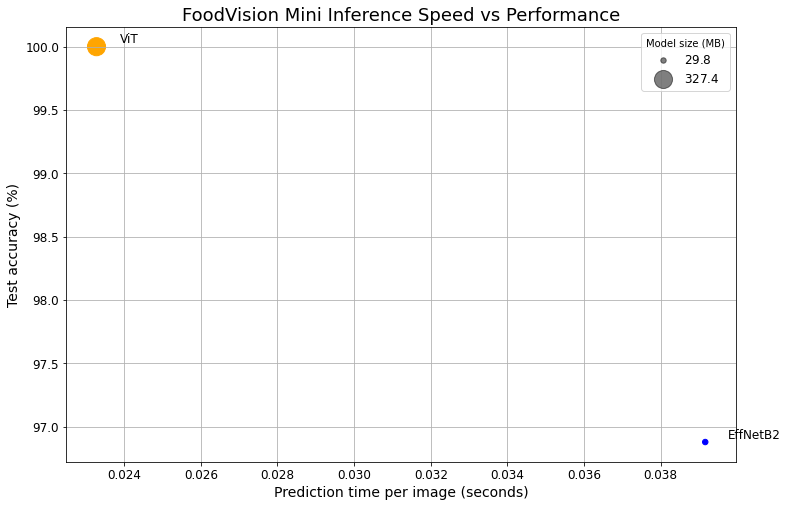

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="avg_time", 
                     y="test_acc", 
                     c=["blue", "orange"],
                     s='model_size') # size the dots by the model sizes

ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"], 
                xy=(row["avg_time"]+0.0006, row["test_acc"]+0.03),
                size=12)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              # loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

plt.savefig("09-foodvision-mini-performance.jpg")

plt.show()

## **Gradio** Deployment

In [ ]:
# Put our model on CPU 
effnetb2 = effnetb2.cpu()

In [ ]:
from typing import Tuple, Dict
from timeit import default_timer as timer

def predict(image) -> Tuple[Dict, float]:
  # Start a timer
  start = timer()
  # Transform the Image
  image = effnetb2_transforms(image).unsqueeze(dim=0)
  # Make Prediction
  effnetb2.eval()
  with torch.inference_mode():
    pred_logits = effnetb2(image)
    pred_prob = torch.softmax(pred_logits, dim=1)

  # Stop the timer
  time = round(timer()-start, 4)

  # Get Dict of all Predictions
  output_dict = {class_names[i]: round(pred_prob[0][i].item(), 2) for i in range(len(class_names)) }

  # return time and all the predictions dict
  return output_dict, time

In [ ]:
import random

path = random.choice(test_data_paths)
image = Image.open(path)

prediction_outputs = predict(image)
prediction_outputs

({'pizza': 0.04, 'steak': 0.8, 'sushi': 0.16}, 0.1169)

In [ ]:
import gradio as gr

examples = [random.choice(list(test_dir.glob(f"{i}/*.jpg"))) for i in class_names]

title = "FoodVisionMini"
description = "Something Something Something..."
article = "cheack out gauravreddy008 on GitHub"

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    title=title,
                    description=description,
                    article=article,
                    examples=examples)

demo.launch(debug=False, 
            share=True)

In [ ]:
import shutil
from pathlib import Path

main_directory = Path("demos/foodvisionmini")

if main_directory.exists():
  shutil.rmtree(main_directory)
  main_directory.mkdir(parents=True, exist_ok=True)
else: 
  main_directory.mkdir(parents=True, exist_ok=True)

examples = [random.choice(list(test_dir.glob(f"{i}/*.jpg"))) for i in class_names]
examples_path = main_directory / 'examples'
examples_path.mkdir(parents=True, exist_ok=True)
for i in examples:
  destination = examples_path / i.name
  shutil.copy2(src=i, dst=destination)

shutil.copy2('effnetb2.pth', main_directory/'effnetb2.pth')

PosixPath('demos/foodvisionmini/effnetb2.pth')

In [ ]:
%%writefile /content/demos/foodvisionmini/model.py

from torch import nn
import torchvision 

SEED = 42 
def create_model(num_classes):

  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = effnetb2_weights.transforms()

  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

  for param in effnetb2.parameters():
    param.requires_grad = False

  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)

  effnetb2.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features = 1408, out_features=num_classes))

  return effnetb2, effnetb2_transforms

Overwriting /content/demos/foodvisionmini/model.py


In [ ]:
%%writefile /content/demos/foodvisionmini/app.py
import os
import gradio as gr
import torch

from model import create_model
from timeit import default_timer as timer
from typing import Tuple, Dict

example_list = [["examples/" + i] for i in os.listdir('examples')]
class_names = ['pizza', 'steak', 'sushi']

model, transforms = create_model(num_classes=3)
model.load_saved_dict('effnetb2.pth', 
                      map_location=torch.device('cpu'))

def predict(image) -> Tuple[Dict, float]:
  start = timer()

  image = transforms(image).unsqueeze(dim=0)
  model.eval()
  with torch.inference_mode():
    pred_logits = model(image)
    pred_prob = torch.softmax(pred_logits, dim=1)

  time = round(timer()-start, 4)
  output_dict = {class_names[i]: round(pred_prob[0][i].item(), 2) for i in range(len(class_names))}

  return output_dict, time

title = "FoodVision(mini)"
description = "# Something Something Something..."
article = "check out gauravreddy08 on GitHub"

demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    title=title,
                    description=description,
                    article=article,
                    examples=example_list)


demo.launch()

Writing /content/demos/foodvisionmini/app.py


In [ ]:
%%writefile /content/demos/foodvisionmini/requirements.txt
torchvision==0.14.1
torch==1.13.1
gradio=3.20.0

Writing /content/demos/foodvisionmini/requirements.txt
